# 01_experiments_dev — MVTec 画像異常検知（開発

本ノートは dev カテゴリのみで設計を確定し、固定パイプライン設定を `assets/fixed_pipeline.json` に出力するためのテンプレートです。
- データ取得は anomalib を用いる（AGENTS.md 準拠）
- 手法は Mahalanobis / PaDiM を比較
- 閾値は dev の test で画像レベル FPR=1% を目標に決定

実行順序：Header → Data → Methods → Results → Save JSON/Artifacts


## 環境・依存の読み込み

In [48]:
# 参考: anomaly_detection.ipynb からの初期インポートを整理
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
from torchvision import models, transforms
from sklearn.covariance import ledoit_wolf
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.express as px
from torch import nn
import torch.nn.functional as F


## データ取得（anomalib 経由）

In [43]:
# AGENTS.md: 既存の MVTEC_ROOT または datasets/MVTecAD を使用。
# 未検出の場合は anomalib によりダウンロード。
MVTEC_ROOT = Path(os.environ.get("MVTEC_ROOT", "datasets/MVTecAD"))
MVTEC_ROOT.mkdir(parents=True, exist_ok=True)

# anomalib のAPIはバージョンで異なる可能性があるため、例示的に記述。
# 実環境の anomalib バージョンに合わせて import と引数を調整してください。
try:
    from anomalib.data import MVTecAD
    datamodule = MVTecAD(root=str(MVTEC_ROOT))
    datamodule.prepare_data()  # download if needed
    datamodule.setup()
except Exception as e:
    print("[WARN] anomalib のデータ取得セットアップで問題が発生しました。バージョンや引数を確認してください:\n", e)

assert MVTEC_ROOT.exists(), "MVTec root not found after anomalib setup."


## 実験設定（dev のみ）

In [50]:
# dev カテゴリと seed を定義
dev_category = "carpet"  # 例: AGENTS.md 推奨例
seeds = [0, 1, 2]
image_size = 256

# 比較する手法（最小構成）
use_mahalanobis = True
use_padim = True

# PaDiM や Mahalanobis で用いる backbone/layers 等は仮パラメータ（要調整）
backbone = "resnet18"
padim_layers = ["layer1", "layer2", "layer3"]
padim_channel_subsample = 100
cov_estimator = "ledoit_wolf"  # Mahalanobis 用


## Methods — Mahalanobis / PaDiM（テンプレート）
- ここで特徴抽出（ImageNet 事前学習）/ 統計量推定 / 推論スコア化を実装します。
- 本テンプレートでは骨子のみを用意しています。必要に応じて `anomaly_detection.ipynb` の実装を移植してください。

#### マハラノビス距離ベースモデル用関数

In [ ]:
def fit_mahalanobis(train_loader, backbone=backbone, cov_estimator=cov_estimator):
    """Fit Mahalanobis model from training data."""
    model = models.__dict__[backbone](pretrained=True)
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor.eval()
    feats = []
    device = next(feature_extractor.parameters()).device
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            feat = feature_extractor(images).view(images.size(0), -1)
            feats.append(feat.cpu().numpy())
    feats = np.concatenate(feats, axis=0)
    mean = feats.mean(axis=0)
    cov, _ = ledoit_wolf(feats)
    precision = np.linalg.pinv(cov)
    model_state = {
        "mean": mean,
        "precision": precision,
        "feature_extractor": feature_extractor,
        "meta": {"backbone": backbone, "cov_estimator": cov_estimator},
    }
    return model_state


def score_mahalanobis(model_state, batch):
    """Return Mahalanobis distances for a batch."""
    feature_extractor = model_state["feature_extractor"]
    device = next(feature_extractor.parameters()).device
    mean = torch.tensor(model_state["mean"], device=device)
    precision = torch.tensor(model_state["precision"], device=device)
    feature_extractor.eval()
    images = batch[0] if isinstance(batch, (tuple, list)) else batch
    images = images.to(device)
    with torch.no_grad():
        feats = feature_extractor(images).view(images.size(0), -1)
    diff = feats - mean
    scores = torch.sqrt(torch.sum((diff @ precision) * diff, dim=1))
    return scores.cpu()

# 任意の DataLoader から全サンプルのマハラノビス距離を算出
def all_mahalanobis_scores(model_state, loader):
    """loader 内のすべての画像についてスコア [N] を返す"""
    chunks = []
    for batch in loader:
        chunks.append(score_mahalanobis(model_state, batch))  # shape [B]
    scores = torch.cat(chunks, dim=0).cpu()  # shape [N]
    return scores



#### PaDiM用関数

In [45]:
class _PadimFeatureExtractor(nn.Module):
    """Utility to capture intermediate feature maps."""

    def __init__(self, backbone, layers):
        super().__init__()
        self.model = models.__dict__[backbone](pretrained=True)
        self.layers = layers
        self.outputs = {}
        for name, module in self.model.named_children():
            if name in layers:
                module.register_forward_hook(self._save_output(name))

    def _save_output(self, name):
        def hook(module, inp, out):
            self.outputs[name] = out
        return hook

    def forward(self, x):
        self.outputs = {}
        _ = self.model(x)
        return [self.outputs[l] for l in self.layers]


def fit_padim(train_loader, backbone=backbone, layers=padim_layers, d=padim_channel_subsample):
    """Fit PaDiM model and return per-location statistics."""
    feature_extractor = _PadimFeatureExtractor(backbone, layers)
    feature_extractor.eval()
    embedding_list = []
    device = next(feature_extractor.parameters()).device
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            feats = feature_extractor(images)
            feats = [
                F.interpolate(f, size=feats[0].shape[-2:], mode="bilinear", align_corners=False)
                for f in feats
            ]
            embedding = torch.cat(feats, dim=1)
            embedding_list.append(embedding.cpu())
    embeddings = torch.cat(embedding_list, dim=0)
    c = embeddings.shape[1]
    h, w = embeddings.shape[2:]
    torch.manual_seed(0)
    idx = torch.randperm(c)[:d]
    embeddings = embeddings[:, idx, :, :]
    embeddings = embeddings.permute(0, 2, 3, 1).reshape(-1, h * w, d)
    mean = embeddings.mean(dim=0)
    cov = torch.zeros(h * w, d, d)
    for i in range(h * w):
        cov[i] = torch.from_numpy(np.cov(embeddings[:, i, :].T))
    return {
        "mean": mean,
        "cov": cov,
        "idx": idx,
        "feature_extractor": feature_extractor,
        "meta": {"backbone": backbone, "layers": layers, "d": d},
    }


def score_padim(model_state, batch):
    """Return PaDiM anomaly scores for batch."""
    feature_extractor = model_state["feature_extractor"]
    device = next(feature_extractor.parameters()).device
    mean = model_state["mean"].to(device)
    cov = model_state["cov"].to(device)
    idx = model_state["idx"]
    feature_extractor.eval()
    images = batch[0] if isinstance(batch, (tuple, list)) else batch
    images = images.to(device)
    with torch.no_grad():
        feats = feature_extractor(images)
        feats = [
            F.interpolate(f, size=feats[0].shape[-2:], mode="bilinear", align_corners=False)
            for f in feats
        ]
        embedding = torch.cat(feats, dim=1)[:, idx, :, :]
    n, d, h, w = embedding.shape
    embedding = embedding.permute(0, 2, 3, 1).reshape(n, h * w, d)
    scores = []
    for emb in embedding:
        dist = []
        for i in range(h * w):
            diff = emb[i] - mean[i]
            inv = torch.linalg.pinv(cov[i])
            dist.append(torch.sqrt(diff @ inv @ diff))
        dist = torch.stack(dist).reshape(h, w)
        scores.append(dist.max())
    return torch.stack(scores).cpu()

def padim_heatmap(model_state, images):
    """画像テンソルから異常スコアヒートマップを計算する

    Args:
        model_state (dict): fit_padimで得たモデル
        images (Tensor[N,C,H,W]): 正規化済み画像

    Returns:
        Tensor[N,H,W]: 異常スコアヒートマップ
    """
    feature_extractor = model_state["feature_extractor"]
    device = next(feature_extractor.parameters()).device
    mean = model_state["mean"].to(device)
    cov = model_state["cov"].to(device)
    idx = model_state["idx"]
    feature_extractor.eval()
    with torch.no_grad():
        feats = feature_extractor(images.to(device))
        feats = [
            F.interpolate(f, size=feats[0].shape[-2:], mode="bilinear", align_corners=False)
            for f in feats
        ]
        embedding = torch.cat(feats, dim=1)[:, idx, :, :]
    n, d, h, w = embedding.shape
    embedding = embedding.permute(0, 2, 3, 1).reshape(n, h * w, d)
    inv_cov = torch.linalg.pinv(cov.to(device))
    maps = []
    for emb in embedding:
        diff = emb - mean
        dist = torch.sqrt(torch.einsum("nd,ndd,nd->n", diff, inv_cov, diff))
        maps.append(dist.reshape(h, w))
    return torch.stack(maps)

def all_padim_scores(model_state, loader, return_maps=False):
    """DataLoader内の全画像についてPaDiMスコアを計算

    Args:
        model_state (dict): fit_padimで得たモデル
        loader (DataLoader): 対象データ
        return_maps (bool): ヒートマップも返すか

    Returns:
        Tensor[N]: 各画像の最大スコア
        Tensor[N,H,W] (optional): ヒートマップ
    """
    scores_list = []
    maps_list = []
    for batch in loader:
        images = batch[0] if isinstance(batch, (list, tuple)) else batch
        maps = padim_heatmap(model_state, images)
        scores_list.append(maps.view(maps.size(0), -1).max(dim=1)[0])
        if return_maps:
            maps_list.append(maps)
    scores = torch.cat(scores_list).cpu()
    if return_maps:
        maps = torch.cat(maps_list).cpu()
        return scores, maps
    return scores


## Results — Cross-Validation & Metrics（テンプレート）
- 各手法で dev の train を用いたクロスバリデーションを実施し、訓練内/訓練外スコアのヒストグラムを確認する。
- dev の test で閾値と評価指標（AUROC, F1 など）の関係を可視化する。


#### データローダー準備

In [46]:
# Data loading for cross-validation (dev train) and dev test
# - Builds KFold train/val DataLoaders using only train/good images.
# - Prepares dev test DataLoader with labels (good=0, defect=1).

from pathlib import Path
from typing import List, Tuple, Any
from PIL import Image
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, Subset
import os

# Transforms (ImageNet mean/std)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

class ImagePathDataset(Dataset):
    """Minimal dataset returning (image_tensor, label).

    Paths: list of filesystem paths; Labels: list[Any] of same length.
    """
    def __init__(self, paths: List[Path], labels: List[Any], transform=None):
        self.paths = [Path(p) for p in paths]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]
        img = Image.open(p).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, y

def _existing_category_root(category: str) -> Path:
    """Find an existing MVTec category root among common layouts.
    Prefers MVTEC_ROOT, then 'datasets/MVTecAD', then 'MVtec_dataset'.
    """
    candidates = [
        MVTEC_ROOT / category,
        Path("datasets/MVTecAD") / category,
        Path("MVtec_dataset") / category,
    ]
    for c in candidates:
        if c.exists():
            return c
    raise FileNotFoundError(f"MVTec category not found: {category}")

def _list_images(d: Path) -> List[Path]:
    exts = {".png", ".jpg", ".jpeg"}
    if not d.exists():
        return []
    return sorted([p for p in d.rglob('*') if p.suffix.lower() in exts])

def build_cv_and_test_loaders(category: str, k_splits: int = 5, batch_size: int = 32) -> Tuple[list, DataLoader]:
    """Return (cv_folds, test_loader).

    cv_folds: list of dicts with 'train_loader' and 'val_loader'.
    test_loader: dev test DataLoader with labels equal to defect types
                 (the directory names directly under 'test', e.g., 'good',
                 'scratch', 'hole', ...).
    """
    root = _existing_category_root(category)
    train_good = _list_images(root / 'train' / 'good')
    assert len(train_good) > 0, f"No train/good images found for {category}"

    # Prepare KFold over indices (all labels are 0 in train).
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=seeds[0] if seeds else 0)
    base_ds = ImagePathDataset(train_good, [0] * len(train_good), transform=_transform)

    num_workers = min(4, os.cpu_count() or 1)
    cv_folds = []
    for fold_id, (tr_idx, va_idx) in enumerate(kf.split(range(len(train_good)))):
        tr_ds = Subset(base_ds, tr_idx)
        va_ds = Subset(base_ds, va_idx)
        tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        cv_folds.append({
            'fold': fold_id,
            'train_loader': tr_loader,
            'val_loader': va_loader,
            'n_train': len(tr_idx),
            'n_val': len(va_idx),
        })

    # Build dev test loader with labels as defect types (dir names under 'test').
    test_dir = root / 'test'
    test_paths: List[Path] = []
    test_labels: List[str] = []
    if test_dir.exists():
        # Iterate over subdirectories directly under 'test' (including 'good').
        for sub in sorted([d for d in test_dir.iterdir() if d.is_dir()], key=lambda p: p.name):
            label = sub.name  # defect type (or 'good')
            paths = _list_images(sub)
            if paths:
                test_paths.extend(paths)
                test_labels.extend([label] * len(paths))
    assert len(test_paths) > 0, f"No test images found for {category}"

    test_ds = ImagePathDataset(test_paths, test_labels, transform=_transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return cv_folds, test_loader

# Build loaders for the chosen dev category
cv_folds, dev_test_loader = build_cv_and_test_loaders(dev_category, k_splits=5, batch_size=32)
print(f"[INFO] Category: {dev_category}")
print(f"[INFO] CV folds: {len(cv_folds)}")
for f in cv_folds:
    print(f"  - fold {f['fold']}: n_train={f['n_train']}, n_val={f['n_val']}")
from collections import Counter
cnt = Counter(dev_test_loader.dataset.labels)
print(f"[INFO] Dev test size: {len(dev_test_loader.dataset)}")
print(f"[INFO] Test label distribution: {dict(cnt)}")


[INFO] Category: carpet
[INFO] CV folds: 5
  - fold 0: n_train=224, n_val=56
  - fold 1: n_train=224, n_val=56
  - fold 2: n_train=224, n_val=56
  - fold 3: n_train=224, n_val=56
  - fold 4: n_train=224, n_val=56
[INFO] Dev test size: 117
[INFO] Test label distribution: {'color': 19, 'cut': 17, 'good': 28, 'hole': 17, 'metal_contamination': 17, 'thread': 19}


#### マハラノビス距離ベースでの異常検知実験

In [39]:
# Example: Fit Mahalanobis model on the first CV fold's training data
# 各フォールドの結果を格納する辞書を初期化
all_results_MD = {}
for ifold, fold in enumerate(cv_folds):
    model_state = fit_mahalanobis(fold['train_loader'])
    scores_train = all_mahalanobis_scores(model_state, fold['train_loader'])
    scores_val = all_mahalanobis_scores(model_state, fold['val_loader'])
    scores_test = all_mahalanobis_scores(model_state, dev_test_loader)

    all_results_MD[ifold] = {
        "model_state": model_state,
        "scores_train": scores_train,
        "scores_val": scores_val,
        "scores_test": scores_test,
    }

    # ヒストグラム用の DataFrame を作成
    df_MD_for_hist = pd.DataFrame({
        "score": np.r_[scores_train.numpy(), scores_val.numpy(), scores_test.numpy()],
        "label": (["train"]*len(scores_train) + ["val"]*len(scores_val) + dev_test_loader.dataset.labels)
    })

    # ヒストグラムの描画
    fig = px.histogram(df_MD_for_hist, x="score", color="label",
                    nbins=30,  # 共通のビン数
                    histnorm=None,  # 形比較なら "probability density"
                    opacity=0.6)
    fig.update_layout(barmode="overlay", title=f"Mahalanobis Scores (Fold {ifold})")
    fig.show()

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.p

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.p

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.p

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.p

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.p

In [ ]:
# 各フォールドのvalデータのスコアのFPR=1%点を計算
for ifold, results in all_results_MD.items():
    scores_val = results["scores_val"].numpy()
    scores_test = results["scores_test"].numpy()
    labels_val = np.array([0]*len(scores_val))  # valデータはすべて正常
    labels_test = np.array([0 if lbl == "good" else 1 for lbl in dev_test_loader.dataset.labels])  # testデータのラベル

    # valデータで閾値を決定（FPR=1%点）
    threshold = np.percentile(scores_val, 99)  # 上位1%を異常とする閾値

    # testデータでの異常検知結果を計算
    preds_test = (scores_test >= threshold).astype(int)

    # 評価指標を計算
    auc = roc_auc_score(labels_test, scores_test)
    f1 = f1_score(labels_test, preds_test)
    print(f"[Fold {ifold}] Val threshold (FPR=1%): {threshold:.4f}, Test AUC: {auc:.4f}, F1: {f1:.4f}")

[Fold 0] Val threshold (FPR=1%): 27.4668, Test AUC: 0.8355
[Fold 1] Val threshold (FPR=1%): 27.2209, Test AUC: 0.8355
[Fold 2] Val threshold (FPR=1%): 31.9090, Test AUC: 0.8391
[Fold 3] Val threshold (FPR=1%): 31.7203, Test AUC: 0.8379
[Fold 4] Val threshold (FPR=1%): 28.4794, Test AUC: 0.8315


#### PaDiMでの異常検知実験

In [51]:
# PaDiM マハラノビス距離ベースと同様に実装

# CV 各フォールドで PaDiM を学習・評価
all_results_PD = {}
for ifold, fold in enumerate(cv_folds):
    model_state = fit_padim(fold["train_loader"])
    scores_train = all_padim_scores(model_state, fold["train_loader"])
    scores_val = all_padim_scores(model_state, fold["val_loader"])
    scores_test, heatmaps_test = all_padim_scores(model_state, dev_test_loader, return_maps=True)

    all_results_PD[ifold] = {
        "model_state": model_state,
        "scores_train": scores_train,
        "scores_val": scores_val,
        "scores_test": scores_test,
        "heatmaps_test": heatmaps_test,
    }

    df_PD = pd.DataFrame({
        "score": np.r_[scores_train.numpy(), scores_val.numpy(), scores_test.numpy()],
        "label": (["train"] * len(scores_train) + ["val"] * len(scores_val) + dev_test_loader.dataset.labels),
    })
    fig = px.histogram(
        df_PD, x="score", color="label", nbins=30, histnorm=None, opacity=0.6
    )
    fig.update_layout(barmode="overlay", title=f"PaDiM Scores (Fold {ifold})")
    fig.show()


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



In [52]:
def inv_transform(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """正規化済み画像テンソルを逆変換してNumPy配列にする"""
    # バッチ次元がある場合は除去
    if img_tensor.dim() == 4:
        img = img_tensor.squeeze(0)
    else:
        img = img_tensor

    # テンソルを NumPy 配列に変換（形状は [3, H, W]）
    img_np = img.cpu().numpy()

    # 逆正規化: 各チャネルについて (x * std + mean)
    mean = np.array(mean)[:, None, None]
    std = np.array(std)[:, None, None]
    img_np = img_np * std + mean

    # 値を [0, 1] にクリップ
    img_np = np.clip(img_np, 0, 1)

    # 軸の順番を [3, H, W] → [H, W, 3] に変換
    img_np = np.transpose(img_np, (1, 2, 0))

    return img_np

[PaDiM Fold 0] Val threshold (FPR=1%): 341.5824, Test AUC: 0.8262, F1: 0.3178
[PaDiM Fold 1] Val threshold (FPR=1%): 254.3922, Test AUC: 0.7913, F1: 0.5323
[PaDiM Fold 2] Val threshold (FPR=1%): 323.2561, Test AUC: 0.7905, F1: 0.3333
[PaDiM Fold 3] Val threshold (FPR=1%): 338.5916, Test AUC: 0.8266, F1: 0.3333
[PaDiM Fold 4] Val threshold (FPR=1%): 252.9048, Test AUC: 0.8018, F1: 0.5938


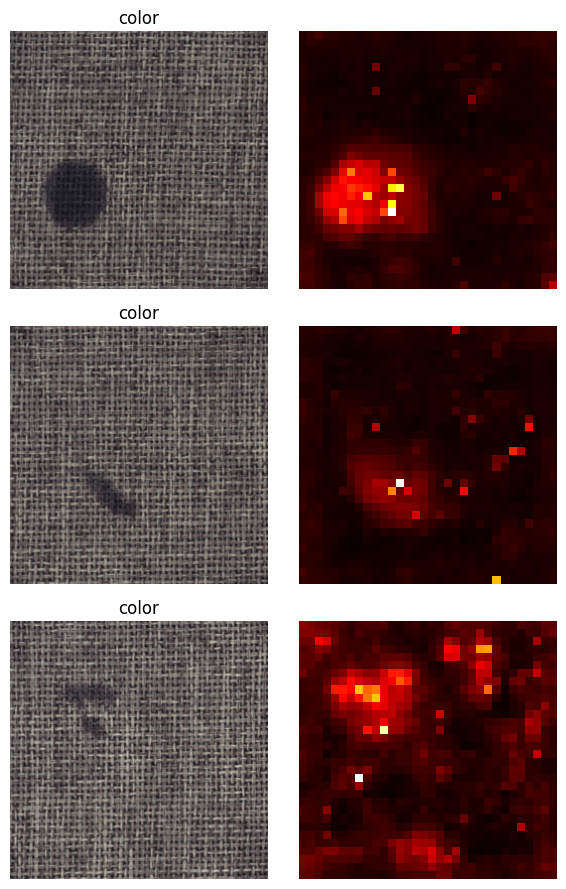

In [53]:
# 評価指標の算出
for ifold, results in all_results_PD.items():
    scores_val = results["scores_val"].numpy()
    scores_test = results["scores_test"].numpy()
    labels_val = np.zeros_like(scores_val)  # valは正常のみ
    labels_test = np.array([0 if lbl == "good" else 1 for lbl in dev_test_loader.dataset.labels])

    threshold = np.percentile(scores_val, 99)
    preds_test = (scores_test >= threshold).astype(int)
    auc = roc_auc_score(labels_test, scores_test)
    f1 = f1_score(labels_test, preds_test)
    print(
        f"[PaDiM Fold {ifold}] Val threshold (FPR=1%): {threshold:.4f}, "
        f"Test AUC: {auc:.4f}, F1: {f1:.4f}"
    )

# テスト画像のヒートマップ表示（最初の3枚）
fig, axes = plt.subplots(3, 2, figsize=(6, 9))
for i in range(3):
    img, lbl = dev_test_loader.dataset[i]
    heatmap = all_results_PD[0]["heatmaps_test"][i].numpy()
    img = inv_transform(img)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(lbl)
    axes[i, 0].axis("off")
    axes[i, 1].imshow(heatmap, cmap="hot")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()


### 閾値決定（FPR=1% 目標、dev の test のみ）

In [ ]:
# NOTE: ここでは閾値決定の骨子のみを用意。
# 実装時は dev の test スコア分布から FPR=1% となるスコアを求めてください。
image_fpr_target = 0.01
good_mask = np.array([lbl == "good" for lbl in dev_test_loader.dataset.labels])
threshold_value = float(np.percentile(all_results_PD[0]["scores_test"].numpy()[good_mask], 99))
threshold_source = f"dev_{dev_category}_test"
print("[INFO] threshold_source:", threshold_source)
print("[INFO] threshold_value:", threshold_value)


## 固定パイプラインの保存（assets/fixed_pipeline.json）

In [ ]:
# デフォルトではファイルを書き出さない（テンプレートのため）。
# 実際に保存したい場合は SAVE_FIXED=True にして実行してください。
SAVE_FIXED = False

fixed_pipeline = {
    "common": {"image_size": image_size, "seeds": seeds},
    "threshold": {"image_fpr_target": image_fpr_target, "value": threshold_value, "source": threshold_source},
    "mahalanobis": {"backbone": backbone, "cov_estimator": cov_estimator},
    "padim": {"layers": padim_layers, "channel_subsample": padim_channel_subsample}
}

assets_dir = Path("assets")
assets_dir.mkdir(parents=True, exist_ok=True)
cfg_path = assets_dir / "fixed_pipeline.json"

if SAVE_FIXED:
    with cfg_path.open("w", encoding="utf-8") as f:
        json.dump(fixed_pipeline, f, indent=2, ensure_ascii=False)
    print(f"[INFO] Saved: {cfg_path}")
else:
    print("[INFO] SAVE_FIXED=False のためファイルは出力しません。")


## 次の手順
- 上記のテンプレート関数に実装を追加し、dev の test から閾値を決めて `SAVE_FIXED=True` で JSON を保存。
- その後 `02_evaluation_report.ipynb` で eval カテゴリを一発評価。
- リーク防止のため、02 ではパラメータ・閾値を変更しないこと。
